In [2]:
import os
import json
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.collections as mc

from src.datasets import get_dataset
from src.modules import get_model, get_loss_fn, get_optimizer


In [75]:
class Snapshot:

    def __init__(self, dir_path, label, sample, epoch, seed):
        self.epoch = epoch
        self.seed = seed
        self.gradient_path = f"{dir_path}/{label}_{sample}/gradient-{epoch}.pt"
        self.config_path = f"{dir_path}/{label}_{sample}/config.json"
        self.checkpoint_path = f"{dir_path}/{label}_{sample}/checkpoint-{epoch}.pt"

    def __call__(self):
        if os.path.exists(self.gradient_path):
            return torch.load(self.gradient_path)
        data = self._process()
        torch.save(data, self.gradient_path)
        return data

    def _process(self):
        self._setup()
        s0 = self._snapshot()
        self._epoch()
        s1 = self._snapshot()
        return {k: (v, s1[k]-v) for k, v in s0.items()}

    def _setup(self):
        with open(self.config_path) as f:
            config = json.load(f)
        self.dataset = get_dataset(config["dataset"], "datasets")
        self.model = get_model(config["model"], self.dataset.input_shape, self.dataset.num_classes)
        self.model.set_epoch(self.epoch)
        self.loss_fn = get_loss_fn(config["fit"]["loss_fn"])
        self.num_samples = config["fit"]["num_samples"]
        self.optimizer = get_optimizer(config["fit"]["optimizer"], self.model.parameters())

        state = torch.load(self.checkpoint_path, map_location="cpu")
        self.model.load_state_dict(state["model"])
        self.optimizer.load_state_dict(state["optimizer"])

    def _epoch(self):
        self.model.eval()
        self.model.train()
        torch.manual_seed(self.seed)

        dataloader = self.dataset.train_loader
        progress = tqdm(dataloader, desc=self.gradient_path)
        for inputs, targets in progress:
            inputs = inputs.unsqueeze(0).expand(self.num_samples, *inputs.shape)
            targets = targets.unsqueeze(0).expand(self.num_samples, *targets.shape)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            losses = self.loss_fn(outputs, targets)
            losses.mean().backward()
            self.optimizer.step()

    def _snapshot(self):
        snapshot = {}
        self._weight(snapshot)
        self._state(snapshot)
        return snapshot

    def _state(self, snapshot):
        for i in range(2, 14, 2):
            s0 = self.model.get_buffer(f"{i}.train_agg.s0").detach().clone()
            s1 = self.model.get_buffer(f"{i}.train_agg.s1").detach().clone()
            s2 = self.model.get_buffer(f"{i}.train_agg.s2").detach().clone()
            snapshot[f"{i}.state.m1"] = s1 / s0
            snapshot[f"{i}.state.m2"] = s2 / s0

    def _weight(self, snapshot):
        for i in range(1, 14, 4):
            b = self.model.get_parameter(f"{i}.bias").detach().clone()
            w = self.model.get_parameter(f"{i}.weight").detach().clone()
            if i < 14-1:
                snapshot[f"{i}.bias"] = b
                snapshot[f"{i}.weight.1t"] = w @ w.T
            if i > 1:
                snapshot[f"{i}.weight.t1"] = w.T @ w


class SwitchSnapshot(Snapshot):

    def __init__(self, dir_path, label0, label1, sample, epoch, seed):
        self.epoch = epoch
        self.seed = seed
        self.gradient_path = f"{dir_path}/{label0}_{sample}/gradient-{label1}_{sample}-{epoch}.pt"
        self.config_path = f"{dir_path}/{label1}_{sample}/config.json"
        self.checkpoint_path = f"{dir_path}/{label0}_{sample}/checkpoint-{epoch}.pt"


class DiffSnapshot(Snapshot):

    def __init__(self, dir_path, label, sample, epoch, seed):
        self.epoch = epoch
        self.seed = seed
        self.gradient_path = f"{dir_path}/{label}_{sample}/gradient-diff-{epoch}.pt"
        self.config_path = f"{dir_path}/{label}_{sample}/config.json"
        self.checkpoint_path = f"{dir_path}/{label}_{sample}/checkpoint-{epoch}.pt"

    def _setup(self):
        super()._setup()
        loss_fn = self.loss_fn
        self.loss_fn = lambda x, y: loss_fn(x, y) - loss_fn(x.mean(0, keepdim=True), y[:1])


In [51]:
def get_epoch_length(cfg):
    learning_rate = cfg["fit"]["optimizer"]["learning_rate"]
    batch_size = cfg["dataset"]["train"]["batch_size"]
    dataset = get_dataset(cfg["dataset"], "datasets")
    dataset_size = len(dataset.train_loader)
    return learning_rate * dataset_size / batch_size

def read_logs(dir_path, labels):
    df_list = []
    for label in labels:
        for sample in range(10):
            try:
                with open(f"{dir_path}/{label}_{sample}/config.json") as f:
                    cfg = json.load(f)
                df = pd.read_json(f"{dir_path}/{label}_{sample}/logs.json")
            except:
                continue
            df["label"] = label
            df["sample"] = sample
            df["epoch"] = df.index + 1
            df["length"] = df["epoch"] * get_epoch_length(cfg)
            df_list.append(df)
    return pd.concat(df_list)

def agg_logs(df, method):
    df = df.groupby(["label", "epoch"], sort=False).agg(method)
    df = df.reset_index().set_index("epoch").groupby("label", sort=False)
    return df

def gridplot(xlabels, ylabels, xsize=2, ysize=2, sharex=True, sharey=True):
    nrows, ncols = len(ylabels), len(xlabels)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, 
        sharex=sharex, sharey=sharey, dpi=100,
        figsize=(ncols*xsize, nrows*ysize))
    if nrows == 1: axes = [axes]
    if ncols == 1: axes = [[ax] for ax in axes]
    for j, xlabel in enumerate(xlabels):
        for i, ylabel in enumerate(ylabels):
            ax = axes[i][j]
            if j == 0 or not sharey: ax.set_ylabel(ylabel)
            if i == len(ylabels)-1 or not sharex: ax.set_xlabel(xlabel)
    return fig, axes

def plot_segments(ax, x0, y0, x1, y1):

    dx = x1 - x0
    dy = y1 - y0
    r = (dx.square() + dy.square() + 1e-8).sqrt()
    n = (r*10).tanh() / r
    c = yuv_color(0.5, dx*n, dy*n)
    ax.scatter(x0, y0, s=1, c=c)

    lc = mc.LineCollection(torch.stack([
        torch.stack([x0, x1], -1), torch.stack([y0, y1], -1)
    ], -1), colors=[tuple(v) for v in c], linewidth=0.5)
    ax.add_collection(lc)

def yuv_color(y, u, v):
    r = y + (1.370705 * v)
    g = y - (0.698001 * v) - (0.337633 * u)
    b = y + (1.732446 * u)
    r = r.clamp(0, 1)
    g = g.clamp(0, 1)
    b = b.clamp(0, 1)
    return torch.stack([r, g, b], -1)

def get_weight(ckpt, i, flip=False):
    w = ckpt["model"][f"{i}.weight"]
    if flip:
        w = w.T
    return w.T @ w

def get_state(ckpt, i):
    s0 = ckpt["model"][f"{i}.train_agg.s0"]
    s2 = ckpt["model"][f"{i}.train_agg.s2"]
    return s2 / s0

def outer(x):
    return x.unsqueeze(-2) * x.unsqueeze(-1)

def norm(x):
    return x * outer(1 / x.diagonal().sqrt())


In [41]:
d = 100
kind = "off-diag"
if kind == "off-diag":
    n = 300
    i = torch.randint(d, size=(n,))
    j = torch.randint(d-1, size=(n,))
    j = j + (j >= i) # skip diagonal
elif kind == "diag":
    i = torch.arange(d)
    j = torch.arange(d)
elif kind == "row":
    i = 0
    j = torch.arange(d)
idx = (i, j)

In [71]:
seed = 2020883518546164801
#dir_path, labels = "outputs/lyr", [f"mean_tanh_l{i}" for l in ("", 1, 2, 3, 123)]
#dir_path, labels = "outputs/dim", [f"mean_tanh_d{i}" for i in (100, 200, 300, 400)]
dir_path, labels = "outputs/std", [f"mean_tanh_s{v}" for v in (0.3, 0.5, 0.7, 1.0)]
#dir_path, labels = "outputs/epc", [f"mean_tanh_b{i}" for i in (0, 10, 20, 30, 40)]
#dir_path, labels = "outputs/epc", [f"mean_tanh_e{i}" for i in (0, 10, 20, 30, 40)]
layers = ["layer 1", "layer 2", "layer 3"]
epochs = [10, 20, 30, 40, 50]
xrange, yrange = (-.5, .5), (-.5, .5)

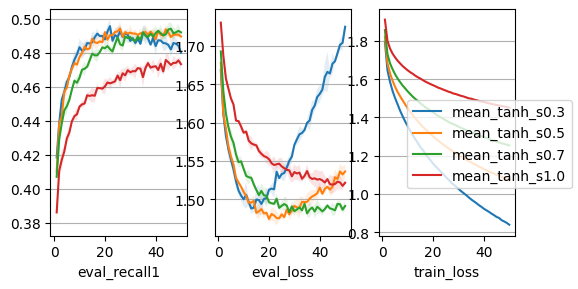

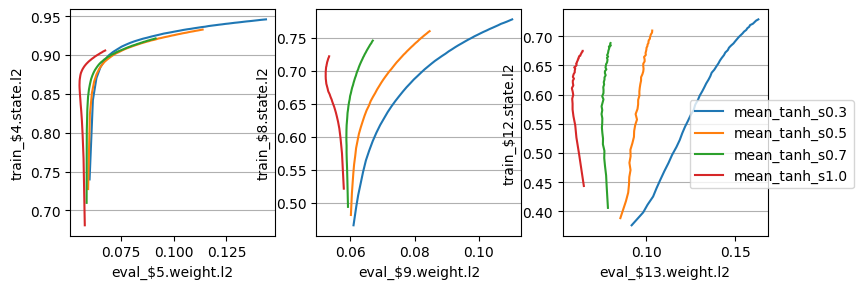

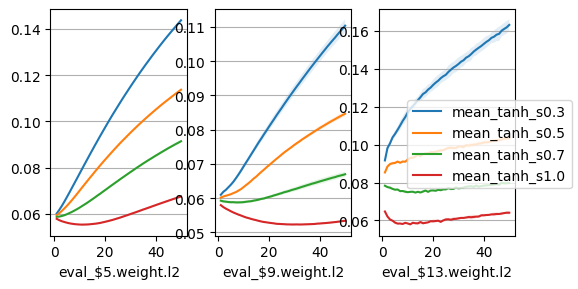

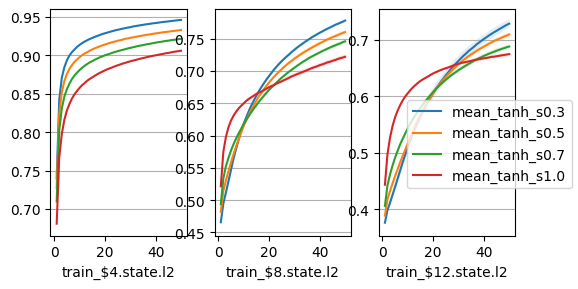

In [72]:
def plot_curve_xy(mdf, xmetrics, ymetrics):
    fig, axes = gridplot(xmetrics, [""], xsize=3, ysize=3, sharex=False, sharey=False)
    for i, (xmetric, ymetric) in enumerate(zip(xmetrics, ymetrics)):
        ax = axes[0][i]
        ax.set_ylabel(ymetric)
        ax.grid(axis="y")
        for (label, x), (_, y) in zip(mdf[xmetric], mdf[ymetric]):
            ax.plot(x, y, label=label)
    fig.legend(*ax.get_legend_handles_labels(), "right")

def plot_curve_std(mdf, sdf, metrics):
    fig, axes = gridplot(metrics, [""], ysize=3, sharey=False)
    for i, metric in enumerate(metrics):
        ax = axes[0][i]
        ax.grid(axis="y")
        for (label, m), (_, s) in zip(mdf[metric], sdf[metric]):
            ax.plot(m, label=label)
            ax.fill_between(m.index, m-s, m+s, alpha=0.125)
    fig.legend(*ax.get_legend_handles_labels(), "right")

weights = [f"eval_${i*4+5}.weight.l2" for i in range(3)]
states = [f"train_${i*4+4}.state.l2" for i in range(3)]
df = read_logs(dir_path, labels)
#scale = df["label"].str.slice(-3).astype(int)
#for weight in weights: df[weight] *= scale
mdf, sdf = agg_logs(df, "mean"), agg_logs(df, "std")
plot_curve_std(mdf, sdf, ["eval_recall1", "eval_loss", "train_loss"])
plot_curve_xy(mdf, weights, states)
plot_curve_std(mdf, sdf, weights)
plot_curve_std(mdf, sdf, states)

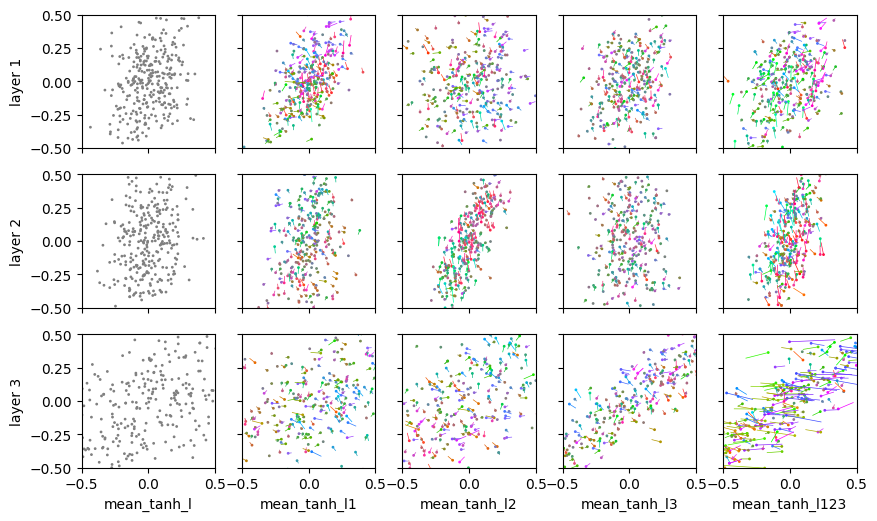

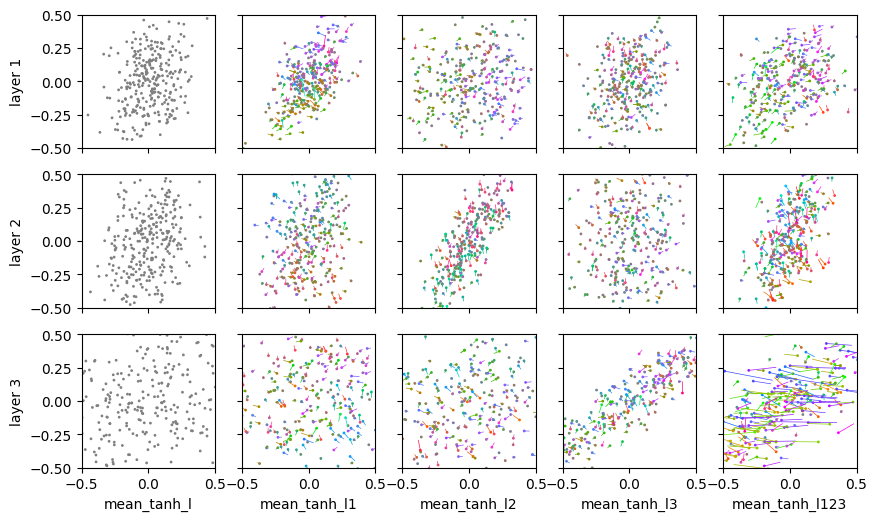

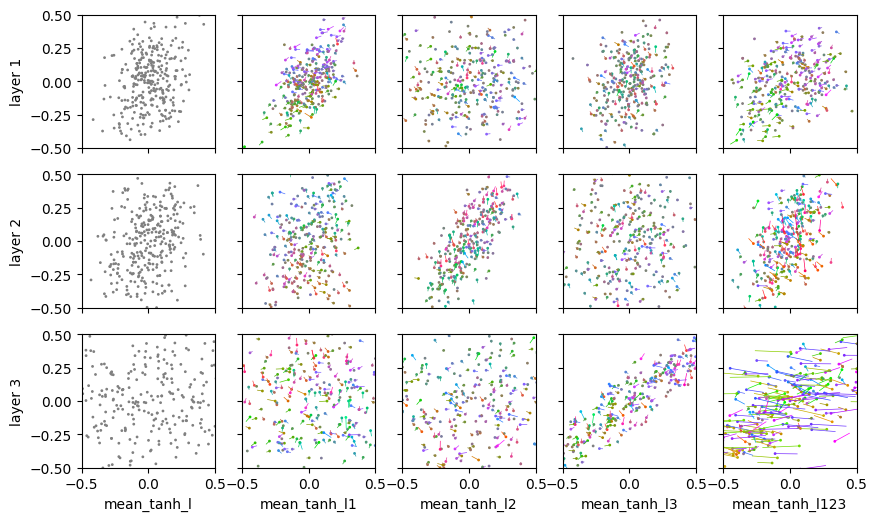

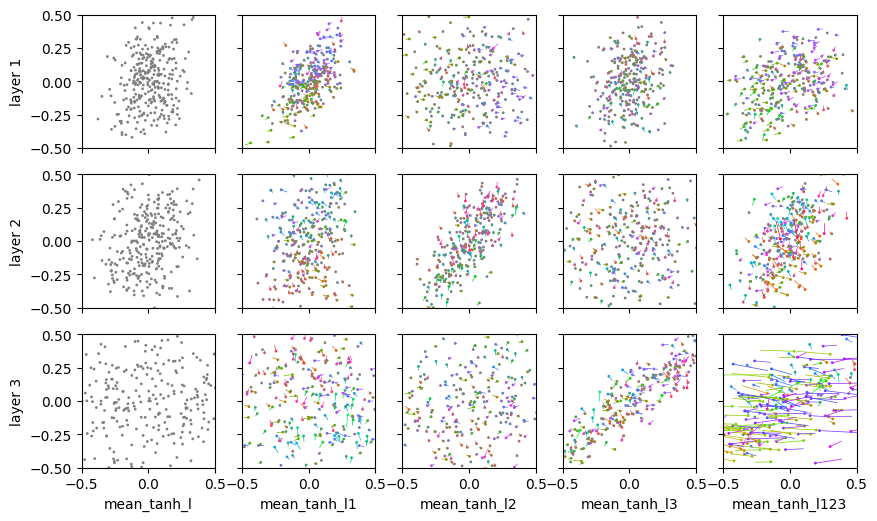

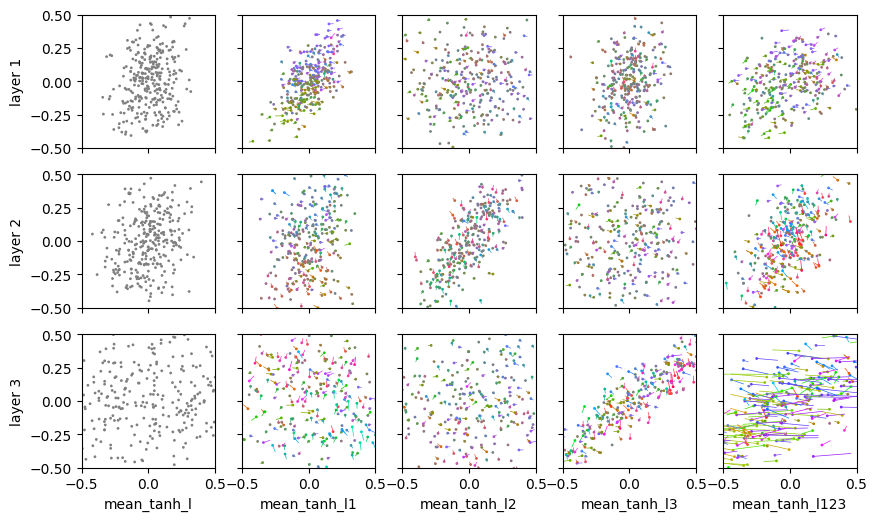

In [55]:
for epoch in epochs:
    _, axes = gridplot(labels, layers)
    for j, label in enumerate(labels):
        speed = 1
        sample = 0
        s = Snapshot(dir_path, label, label, sample, epoch, seed)()
        t = Snapshot(dir_path, label, labels[0], sample, epoch, seed)()
        for i, layer in enumerate(layers):
            ax = axes[i][j]
            ax.set_xlim(*xrange)
            ax.set_ylim(*yrange)
            kx = f"{i*4+5}.weight.t1"
            ky = f"{i*4+4}.state.m2"
            #ky = f"{i*4+2}.state.m2"
            #ky = f"{i*4+1}.weight.1t"
            x0, dx = s[kx][0], s[kx][1] - t[kx][1]
            y0, dy = s[ky][0], s[ky][1] - t[ky][1]
            x1, y1 = x0 + dx * speed, y0 + dy * speed
            x0, x1 = norm(x0)[idx], norm(x1)[idx]
            y0, y1 = norm(y0)[idx], norm(y1)[idx]
            plot_segments(ax, x0, y0, x1, y1)

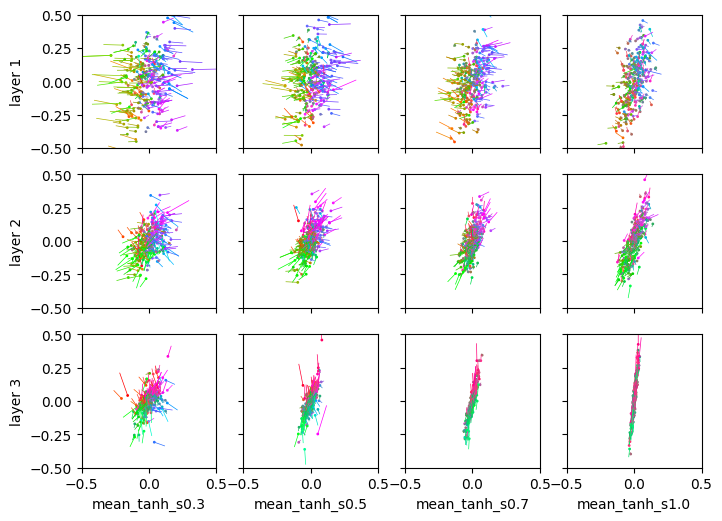

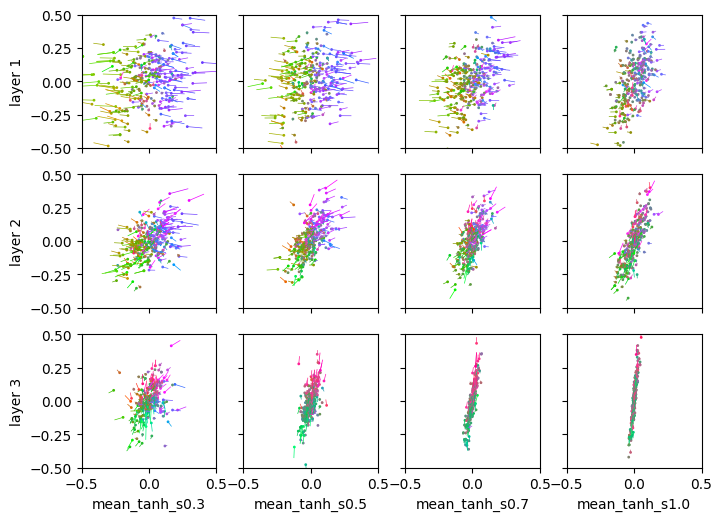

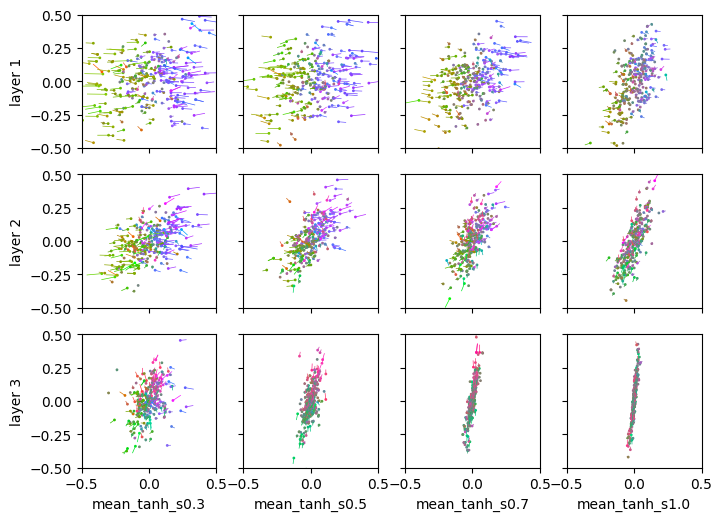

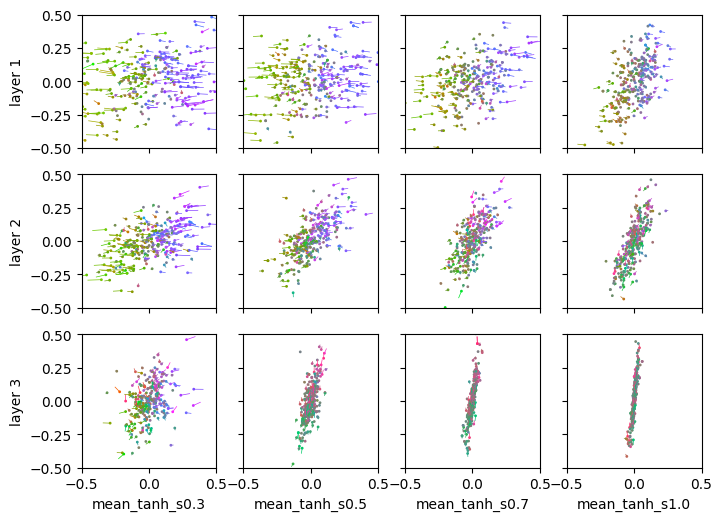

In [74]:
for epoch0, epoch1 in zip(epochs[:-1], epochs[1:]):
    _, axes = gridplot(labels, layers)
    for j, label in enumerate(labels):
        speed = 10
        sample = 0
        ckpt0 = torch.load(f"{dir_path}/{label}_{sample}/checkpoint-{epoch0}.pt", map_location="cpu")
        ckpt1 = torch.load(f"{dir_path}/{label}_{sample}/checkpoint-{epoch1}.pt", map_location="cpu")
        for i, layer in enumerate(layers):
            ax = axes[i][j]
            ax.set_xlim(*xrange)
            ax.set_ylim(*yrange)
            x0 = get_weight(ckpt0, i*4+5)[idx]
            x1 = get_weight(ckpt1, i*4+5)[idx]
            y0 = get_state(ckpt0, i*4+4)[idx]
            y1 = get_state(ckpt1, i*4+4)[idx]
            a = speed / (epoch1 - epoch0)
            plot_segments(ax, x0, y0, x0+(x1-x0)*a, y0+(y1-y0)*a)